In [1]:


## 1. 定义模型
import torch.nn as nn
from transformers import BertModel, BertTokenizer
class BertClassifier(nn.Module):
    def __init__(self, bert_config, num_labels):
        super().__init__()
        # 定义BERT模型
        self.bert = BertModel(config=bert_config)
        # 定义分类器
        self.classifier = nn.Linear(bert_config.hidden_size, num_labels)
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]
        logits = self.classifier(pooled_output)
        return logits
    
    
class BertLstmClassifier(nn.Module):
    def __init__(self, bert_config, num_labels):
        super().__init__()
        self.bert = BertModel(config=bert_config)
        self.lstm = nn.LSTM(bert_config.hidden_size, bert_config.hidden_size, num_layers=2,batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(bert_config.hidden_size * 2, num_labels) ## 双向LSTM
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs.last_hidden_state
        lstm_output, _ = self.lstm(sequence_output)
        logits = self.classifier(lstm_output[:, -1, :])
        return logits
    


In [2]:
from torch.utils.data import Dataset
import json
import numpy as np
import torch
import sys
from transformers import BertTokenizer

class _2016Dataset(Dataset):
    def __init__(
        self, file_path, tokenizer, max_length=1024, is_dynamic_max_length=True
    ):
        self.lib_labels = ["moved", "angry", "funny", "sad", "novel", "shocked"]
        self.label_to_id = {label: i for i, label in enumerate(self.lib_labels)}
        self.id_to_label = {i: label for i, label in enumerate(self.lib_labels)}
        self.tokenizer = tokenizer
        self.input_ids = []
        self.attention_mask = []
        self.token_type_ids = []
        self.label_scores = []
        self.max_length = max_length
        self.load_data(file_path, is_dynamic_max_length)

    def load_data(self, file_path, is_dynamic_max_length):
        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)
        if is_dynamic_max_length:
            for item in data:
                text = item["news"].replace(" ", "")
                self.max_length = min(512, max(self.max_length, len(text)))
        for item in data:
            text = item["news"].replace(" ", "")  # 移除空格
            # 提取情感值并转换为整数
            emotions = {k: int(v) for k, v in item.items() if k in self.lib_labels}
            total = int(item["Total"])  # 确保 Total 也转换为整数

            # 情感强度归一化
            if total > 0:
                label_vector = [emotions[label] / total for label in self.lib_labels]
            else:
                label_vector = [0.0] * len(
                    self.lib_labels
                )  # 如果 Total 为 0，所有情感归为 0

            # Tokenization
            token = self.tokenizer(
                text,
                max_length=self.max_length,
                add_special_tokens=True,
                padding="max_length",
                truncation=True,
                return_tensors="pt",
            )
            self.input_ids.append(token["input_ids"].clone().detach())
            self.attention_mask.append(token["attention_mask"].clone().detach())
            self.token_type_ids.append(token["token_type_ids"].clone().detach())
            self.label_scores.append(torch.tensor(label_vector, dtype=torch.float))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return (
            self.input_ids[idx].squeeze(0),
            self.attention_mask[idx].squeeze(0),
            self.token_type_ids[idx].squeeze(0),
            self.label_scores[idx],
        )


tokenizer = BertTokenizer.from_pretrained(
    "model/bert-base-chinese"
)  # 替换为适合的 tokenizer 路径
test_data = _2016Dataset("data/2016.json", tokenizer)
print("数据集长度:", len(test_data))
input_ids, attention_mask, token_type_ids, label_scores = test_data[2]

# 解码文本
decoded_text = tokenizer.decode(input_ids.tolist(), skip_special_tokens=True)
print("解码后的文本:", decoded_text)
print("情感强度向量:", label_scores.numpy())

# 输出对应情感标签和归一化值
print("情感标签及归一化值:")
for i, score in enumerate(label_scores.numpy()):
    print(f"{test_data.id_to_label[i]}: {score:.4f}")


print("数据加载成功...", file=sys.stderr)

数据集长度: 5257
解码后的文本: 女 子 与 情 夫 偷 情 时 遭 歹 徒 强 暴 情 夫 争 执 中 被 杀 商 报 消 息 （ 庞 孝 君 记 者 郑 芷 南 通 讯 员 孙 明 华 付 朝 旺 ） 聊 城 一 女 子 在 家 中 与 同 村 男 子 偷 情 时 ， 被 突 然 闯 入 的 两 名 陌 生 人 带 走 施 暴 ， 而 其 情 夫 在 与 两 人 争 执 过 程 中 死 亡 。 日 前 ， 聊 城 市 东 昌 府 警 方 侦 破 了 这 起 强 奸 案 ， 并 带 破 了 10 余 起 盗 窃 案 ， 犯 罪 嫌 疑 人 魏 某 、 吕 某 被 东 昌 府 警 方 缉 拿 归 案 。 今 年 8 月 16 日 ， 东 昌 府 公 安 分 局 刑 侦 五 中 队 接 梁 水 镇 派 出 所 移 交 案 件 ： 8 月 15 日 23 时 许 ， 梁 水 镇 的 女 子 栾 某 与 其 村 男 子 王 某 在 家 中 偷 情 时 ， 两 名 男 子 闯 进 栾 某 家 中 ， 与 王 某 发 生 争 执 ， 而 后 两 名 男 子 强 行 将 栾 某 带 至 一 空 宅 内 强 奸 。 栾 某 回 到 家 中 时 发 现 王 某 死 亡 。 案 发 后 ， 技 术 民 警 对 现 场 进 行 勘 查 及 尸 体 检 验 。 办 案 民 警 围 绕 现 场 物 证 、 周 边 监 控 录 像 及 受 害 人 关 系 网 等 展 开 全 面 摸 排 工 作 ， 最 终 在 距 案 发 地 两 公 里 处 发 现 可 疑 车 辆 。 为 此 ， 民 警 立 即 对 案 发 现 场 周 边 可 疑 年 龄 段 且 有 前 科 人 员 展 开 重 点 摸 排 。 经 细 致 比 对 ， 梁 水 镇 辖 区 魏 某 曾 被 劳 动 教 养 ， 且 有 一 辆 面 包 车 与 嫌 疑 车 辆 相 似 ， 有 重 大 作 案 嫌 疑 。 同 时 ， 办 案 民 警 锁 定 斗 虎 屯 辖 区 的 吕 某 有 重 大 嫌 疑 。 在 确 定 嫌 疑 人 行 踪 后 ， 9 月 12 日 ， 民 警 兵 分 两 路 展 开 抓 捕 行 动 。 当 日 11 时 许 ， 犯 罪 嫌 疑 人 吕 某 （ 男 ， 44 岁 ） 在 其 家 门 口 被 成 功 抓 获 。

数据加载成功...


In [3]:
#分割数据集
import json
import random

# 加载原始数据集
with open('data/2016.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# 打乱数据集
random.shuffle(data)

# 分割数据集
split_index = int(len(data) * 0.8)
train_data = data[:split_index]
test_data = data[split_index:]

# 保存训练集到 train.json
with open('data/train.json', 'w', encoding='utf-8') as train_file:
    json.dump(train_data, train_file, ensure_ascii=False, indent=4)

# 保存测试集到 test.json
with open('data/test.json', 'w', encoding='utf-8') as test_file:
    json.dump(test_data, test_file, ensure_ascii=False, indent=4)

print(f"训练集大小: {len(train_data)}")
print(f"测试集大小: {len(test_data)}")

训练集大小: 4205
测试集大小: 1052


In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from scipy.stats import pearsonr
from tqdm import tqdm
import torch.nn.functional as F
def train(
    model,
    train_dataset,
    val_dataset,
    epochs=10,
    batch_size=5,
    learning_rate=2e-5,
    weight_decay=1e-4,
    patience=3,
    device="cuda" if torch.cuda.is_available() else "cpu",
):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    loss_fn = nn.KLDivLoss(reduction='batchmean')
    model.to(device)

    train_losses = []
    train_accuracies = []
    train_pearsons = []
    val_accuracies = []
    val_pearsons = []
    best_val_loss = float('inf')
    no_improve_epochs = 0

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        pearson_sum = 0
        pearson_count = 0

        train_loader_tqdm = tqdm(train_loader, desc="Training Loss=0.0000", leave=False)

        for batch in train_loader_tqdm:
            input_ids, attention_mask, token_type_ids, label_scores = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)

            optimizer.zero_grad()

            logits = model(input_ids, attention_mask, token_type_ids)
            predicted_probs = F.softmax(logits, dim=1)
            loss = loss_fn(predicted_probs, label_scores.to(device))
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

            _, pred = torch.max(logits, dim=1)
            correct += (pred == torch.argmax(label_scores, dim=1).to(device)).sum().item()
            total += label_scores.size(0)

            # Update Pearson correlation
            for i in range(logits.size(0)):
                pearson, _ = pearsonr(logits[i].cpu().detach().numpy(), label_scores[i].cpu().detach().numpy())
                pearson_sum += pearson
                pearson_count += 1

            # 动态更新 tqdm 描述
            avg_loss_so_far = train_loss / (train_loader_tqdm.n + 1)
            train_loader_tqdm.set_description(f"Training Loss={avg_loss_so_far:.4f}")

        train_accuracy = correct / total
        avg_train_loss = train_loss / len(train_loader)
        avg_pearson = pearson_sum / pearson_count

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        train_pearsons.append(avg_pearson)

        print(f"Train Loss={avg_train_loss:.4f}, Train Accuracy={train_accuracy:.4f}, Train Pearson={avg_pearson:.4f}")

        # 验证阶段
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        pearson_sum = 0
        pearson_count = 0

        val_loader_tqdm = tqdm(val_loader, desc="Validating Loss=0.0000", leave=False)

        with torch.no_grad():
            for batch in val_loader_tqdm:
                input_ids, attention_mask, token_type_ids, label_scores = batch
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                token_type_ids = token_type_ids.to(device)

                logits = model(input_ids, attention_mask, token_type_ids)

                predicted_probs = F.softmax(logits, dim=1)
                loss = loss_fn(predicted_probs, label_scores.to(device))
                val_loss += loss.item()

                _, pred = torch.max(logits, dim=1)
                correct += (pred == torch.argmax(label_scores, dim=1).to(device)).sum().item()
                total += label_scores.size(0)

                for i in range(logits.size(0)):
                    pearson, _ = pearsonr(logits[i].cpu().numpy(), label_scores[i].cpu().numpy())
                    pearson_sum += pearson
                    pearson_count += 1

                # 动态更新 tqdm 描述
                avg_loss_so_far = val_loss / (val_loader_tqdm.n + 1)
                val_loader_tqdm.set_description(f"Validating Loss={avg_loss_so_far:.4f}")

        val_accuracy = correct / total
        avg_val_loss = val_loss / len(val_loader)
        avg_pearson = pearson_sum / pearson_count

        val_accuracies.append(val_accuracy)
        val_pearsons.append(avg_pearson)

        print(f"Validation Loss={avg_val_loss:.4f}, Validation Accuracy={val_accuracy:.4f}, Validation Pearson={avg_pearson:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print("Early stopping triggered.")
                break

        scheduler.step()

    print("Training Complete")
    return train_losses, train_accuracies, train_pearsons, val_accuracies, val_pearsons



Epoch 1/20


Train Loss=-1.4076, Train Accuracy=0.3643, Train Pearson=0.2844


Validation Loss=-1.4210, Validation Accuracy=0.3726, Validation Pearson=0.2948
Epoch 2/20


Train Loss=-1.4083, Train Accuracy=0.3646, Train Pearson=0.2839


Validation Loss=-1.4210, Validation Accuracy=0.3726, Validation Pearson=0.2916
Epoch 3/20


Train Loss=-1.4085, Train Accuracy=0.3646, Train Pearson=0.2829


Validation Loss=-1.4210, Validation Accuracy=0.3726, Validation Pearson=0.2909
Epoch 4/20


Train Loss=-1.4083, Train Accuracy=0.3646, Train Pearson=0.2824


Validation Loss=-1.4210, Validation Accuracy=0.3726, Validation Pearson=0.2909
Epoch 5/20


Train Loss=-1.4084, Train Accuracy=0.3646, Train Pearson=0.2823


Validation Loss=-1.4210, Validation Accuracy=0.3726, Validation Pearson=0.2909
Epoch 6/20


Train Loss=-1.4083, Train Accuracy=0.3646, Train Pearson=0.2823


Validation Loss=-1.4210, Validation Accuracy=0.3726, Validation Pearson=0.2909
Epoch 7/20


Train Loss=-1.4085, Train Accuracy=0.3646, Train Pearson=0.2822


Validation Loss=-1.4210, Validation Accuracy=0.3726, Validation Pearson=0.2908
Epoch 8/20


Train Loss=-1.4085, Train Accuracy=0.3646, Train Pearson=0.2822


Validation Loss=-1.4210, Validation Accuracy=0.3726, Validation Pearson=0.2908
Epoch 9/20


Train Loss=-1.4083, Train Accuracy=0.3646, Train Pearson=0.2823


Validation Loss=-1.4210, Validation Accuracy=0.3726, Validation Pearson=0.2908
Epoch 10/20


Train Loss=-1.4083, Train Accuracy=0.3646, Train Pearson=0.2823


Validation Loss=-1.4210, Validation Accuracy=0.3726, Validation Pearson=0.2908
Epoch 11/20


Train Loss=-1.4085, Train Accuracy=0.3646, Train Pearson=0.2822


Validation Loss=-1.4210, Validation Accuracy=0.3726, Validation Pearson=0.2908
Epoch 12/20


Train Loss=-1.4083, Train Accuracy=0.3646, Train Pearson=0.2822


Validation Loss=-1.4210, Validation Accuracy=0.3726, Validation Pearson=0.2908
Epoch 13/20


Train Loss=-1.4085, Train Accuracy=0.3646, Train Pearson=0.2823


Validation Loss=-1.4210, Validation Accuracy=0.3726, Validation Pearson=0.2908
Epoch 14/20


Train Loss=-1.4085, Train Accuracy=0.3646, Train Pearson=0.2823


Validation Loss=-1.4210, Validation Accuracy=0.3726, Validation Pearson=0.2908
Epoch 15/20


Train Loss=-1.4082, Train Accuracy=0.3646, Train Pearson=0.2822


Validation Loss=-1.4210, Validation Accuracy=0.3726, Validation Pearson=0.2908
Epoch 16/20


Train Loss=-1.4084, Train Accuracy=0.3646, Train Pearson=0.2823


Validation Loss=-1.4210, Validation Accuracy=0.3726, Validation Pearson=0.2908
Epoch 17/20


Train Loss=-1.4086, Train Accuracy=0.3646, Train Pearson=0.2823


Validation Loss=-1.4210, Validation Accuracy=0.3726, Validation Pearson=0.2908
Epoch 18/20


Train Loss=-1.4085, Train Accuracy=0.3646, Train Pearson=0.2822


Validation Loss=-1.4210, Validation Accuracy=0.3726, Validation Pearson=0.2908
Early stopping triggered.
Training Complete


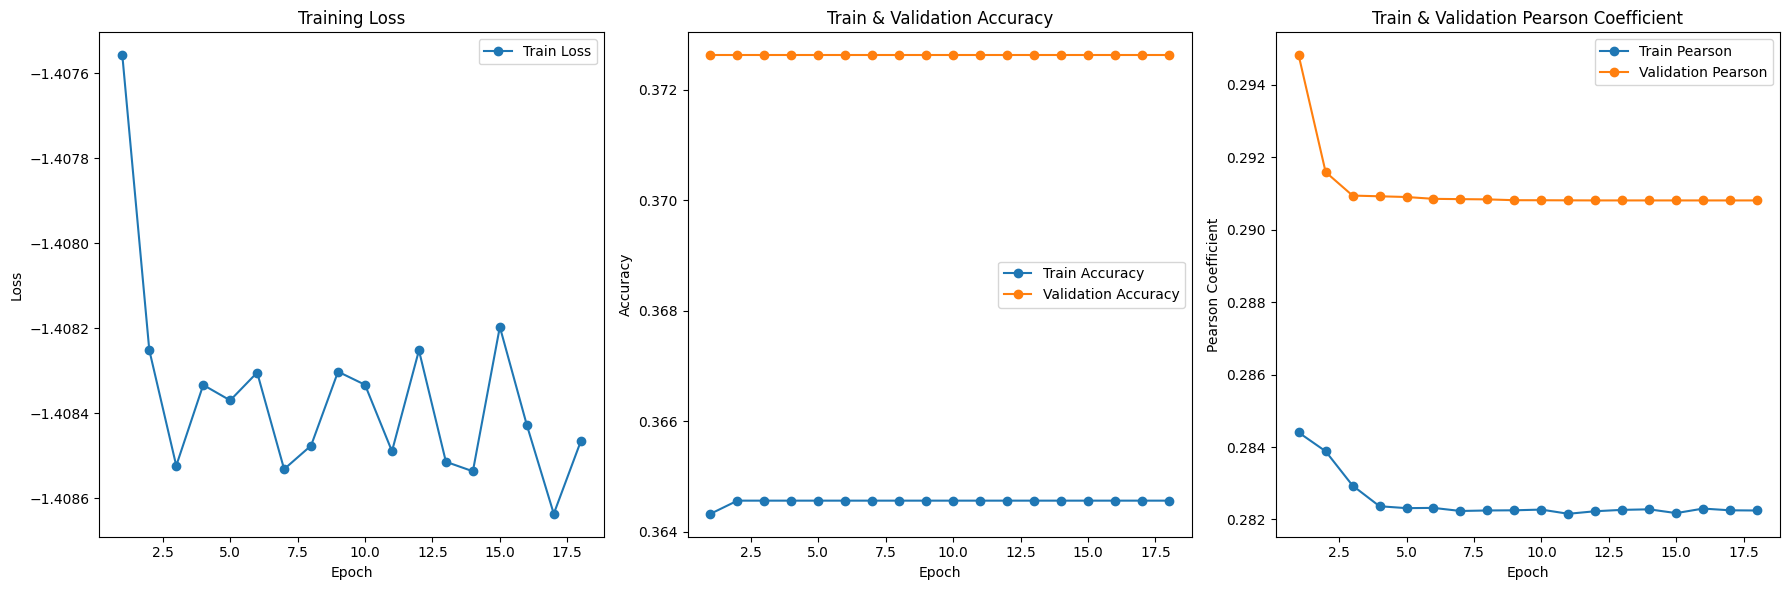

In [5]:
# 运行训练过程并获取分类报告数据、训练损失和验证损失
import matplotlib.pyplot as plt
from transformers import BertConfig, BertTokenizer

tokenizer = BertTokenizer.from_pretrained('model/bert-base-chinese')  
model = BertClassifier(BertConfig.from_pretrained('model/bert-base-chinese'), num_labels=6)  
train_dataset = _2016Dataset('data/train.json', tokenizer)
val_dataset = _2016Dataset('data/test.json', tokenizer)
# 调用训练函数
train_losses, train_accuracies, train_pearsons, val_accuracies, val_pearsons = train(
    model, 
    train_dataset, 
    val_dataset, 
    epochs=20, 
    batch_size=8, 
    learning_rate=2e-5
)

# 绘制训练过程中的 Loss、Accuracy 和 Pearson Coefficient 曲线
plt.figure(figsize=(18, 6))

# Loss 曲线
plt.subplot(1, 3, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Accuracy 曲线
plt.subplot(1, 3, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy", marker="o")
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train & Validation Accuracy")
plt.legend()

# Pearson Coefficient 曲线
plt.subplot(1, 3, 3)
plt.plot(range(1, len(train_pearsons) + 1), train_pearsons, label="Train Pearson", marker="o")
plt.plot(range(1, len(val_pearsons) + 1), val_pearsons, label="Validation Pearson", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Pearson Coefficient")
plt.title("Train & Validation Pearson Coefficient")
plt.legend()

plt.tight_layout()
plt.show()
